In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import random

# for consistency, all seeds are set to 0
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

## Model Config
Config necessery params here


In [ ]:
class configure():
  def __init__(self):
    self.save = 'path or False' # if you don't want to save Gen image
    self.size = 128 #Image Size
    self.batch_size = 16
    self.datasetspath = 'Your Path' #As Numpy Array Only
    self.save_gen = 'Your Path' #generator save path
    self.save_dis = 'Your Path' #generator save path
    self.ema_save = 'Your Path' #Ema Savepath

    self.gen_load = 'Gen State dict path' #please provide False if you don't load
    self.dis_load = 'Dis State dict path' 

config = configure()

In [ ]:
num_epochs = [500, 400, 300, 200, 100, 50] # I'll take forever if you use K80 with this config

# Dataloader

In [ ]:
from tqdm import tqdm
import torchvision.transforms as transforms

size = config.size
batch_size = config.batch_size

temp = np.load(f'{config.datasetspath}')/127.5-1
temp0 = np.moveaxis(temp,-1,1)[0:] 
del temp
temp = torch.tensor(temp0).float()
del temp0

train_loader = torch.utils.data.DataLoader(temp, 
                                           batch_size=batch_size, 
                                           num_workers=2, 
                                           shuffle=True,
                                           )

del temp

## Visualizer Function

In [ ]:
def plotter(data, save=False):
  data = torch.moveaxis(data*127.5+127.5,1,-1).numpy().astype('uint8')
  fig,ax = plt.subplots(4,4,figsize=(5,5))
  for i in range(4):
    for j in range(4):
      ax[i,j].imshow(data[i+4*j])
      ax[i,j].axis('off')

  if save != False:
    print('Save...')
    plt.savefig(save)
    plt.close('all')
    return

  print('----------Show_Visualize----------')
  plt.show()

In [ ]:
def double_plotter(data):
  data = torch.moveaxis(data*127.5+127.5,1,-1).numpy().astype(int)
  fig,ax = plt.subplots(2,2,figsize=(10,10))
  for i in range(2):
    for j in range(2):
      ax[i,j].imshow(data[i+2*j])
      ax[i,j].axis('off')

  plt.show()

----------Show_Visualize----------


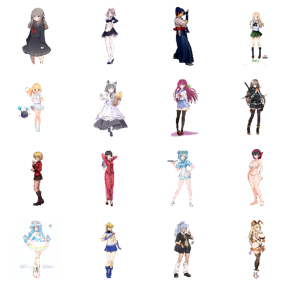

In [ ]:
for data in train_loader:
  plotter(data)
  break

# Model

In [ ]:
factors = [1, 1, 1, 1, 1 / 2, 1 / 4, 1 / 8, 1 / 16, 1 / 32] #Just A Scaling Factor Don't Change buy you can add 64, 128

In [ ]:
# PixelNorm : L2 norm on each pixel (dim=1)

class PixelNorm(nn.Module):
  def __init__(self):
    super(PixelNorm, self).__init__()
  def forward(self, x):
    return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + 1e-8)

In [ ]:
# Linear (dense) layer with scaling and weight initalizations

class WeightedScaledLinear(nn.Module):

  def __init__(self, in_features, out_features, gain=2):

    super(WeightedScaledLinear, self).__init__()

    self.linear = nn.Linear(in_features, out_features)
    self.scale = (gain / in_features)**0.5
    self.bias = self.linear.bias
    self.linear.bias = None

    # initialize linear layer
    nn.init.normal_(self.linear.weight)
    nn.init.zeros_(self.bias)

  def forward(self, x):

    return self.linear(x * self.scale) + self.bias

# Conv2d layer with scaling and weight initalizations

class WeightedScaledConv2d(nn.Module):

  def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, gain=2,):

    super(WeightedScaledConv2d, self).__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
    self.scale = (gain / (in_channels * (kernel_size ** 2))) ** 0.5
    self.bias = self.conv.bias
    self.conv.bias = None

    # initialize conv layer
    nn.init.normal_(self.conv.weight)
    nn.init.zeros_(self.bias)

  def forward(self, x):
    
    return self.conv(x * self.scale) + self.bias.view(1, self.bias.shape[0], 1, 1)

In [ ]:
# Controls how much noise is injected with the weights parameter. Noise are injected every growing resolutions

class InjectNoise(nn.Module):

  def __init__(self, channels):

    super(InjectNoise, self).__init__()
    self.weight = nn.Parameter(torch.zeros(1, channels, 1, 1))

  def forward(self, x):
    
    noise = torch.randn((x.shape[0], 1, x.shape[2], x.shape[3]), device=x.device)
    return x + self.weight * noise

In [ ]:
# AdaIN : pixelnorm with affine scaling like the ones in batch norm
class AdaIN(nn.Module):
  def __init__(self, channels, w_dim):
    super().__init__()
    self.instance_norm = nn.InstanceNorm2d(channels)
    self.style_scale = WeightedScaledLinear(w_dim, channels)
    self.style_bias = WeightedScaledLinear(w_dim, channels)

  def forward(self, x, w):
    x = self.instance_norm(x)
    style_scale = self.style_scale(w).unsqueeze(2).unsqueeze(3)
    style_bias = self.style_bias(w).unsqueeze(2).unsqueeze(3)
    return style_scale * x + style_bias

## Network

In [ ]:
# 8 linear layers to transform noise of dimension z_dim into style vector of dimension w_dim
# PixelNorm is basically used interchangably with L2 norm here

class MappingNetwork(nn.Module):

  def __init__(self, z_dim, w_dim):

    super(MappingNetwork, self).__init__()

    self.mapping = nn.Sequential(
        PixelNorm(),
        WeightedScaledLinear(z_dim, w_dim),
        nn.ReLU(),
        WeightedScaledLinear(w_dim, w_dim),
        nn.ReLU(),
        WeightedScaledLinear(w_dim, w_dim),
        nn.ReLU(),
        WeightedScaledLinear(w_dim, w_dim),
        nn.ReLU(),
        WeightedScaledLinear(w_dim, w_dim),
        nn.ReLU(),
        WeightedScaledLinear(w_dim, w_dim),
        nn.ReLU(),
        WeightedScaledLinear(w_dim, w_dim),
        nn.ReLU(),
        WeightedScaledLinear(w_dim, w_dim),
    )

  def forward(self, x):
    return self.mapping(x)

In [ ]:
#Noise and style vector injection right after upsampling
class GenBlock(nn.Module):

  def __init__(self, in_channels, out_channels, w_dim):
    super(GenBlock, self).__init__()
    self.conv1 = WeightedScaledConv2d(in_channels, out_channels)
    self.conv2 = WeightedScaledConv2d(out_channels, out_channels)
    self.leaky = nn.LeakyReLU(0.2, inplace=True)
    self.inject_noise1 = InjectNoise(out_channels)
    self.inject_noise2 = InjectNoise(out_channels)
    self.adain1 = AdaIN(out_channels, w_dim)
    self.adain2 = AdaIN(out_channels, w_dim)

  def forward(self, x, w):
    x = self.adain1(self.leaky(self.inject_noise1(self.conv1(x))), w)
    x = self.adain2(self.leaky(self.inject_noise2(self.conv2(x))), w)
    return x

In [ ]:
#2 convolutions after noise and vector injection, used in both gen and dis

class ConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(ConvBlock, self).__init__()
    self.conv1 = WeightedScaledConv2d(in_channels, out_channels)
    self.conv2 = WeightedScaledConv2d(out_channels, out_channels)
    self.leaky = nn.LeakyReLU(0.2)

  def forward(self, x):
    x = self.leaky(self.conv1(x))
    x = self.leaky(self.conv2(x))
    return x

In [ ]:
class StyleGenerator(nn.Module):

  def __init__(self, z_dim, w_dim, in_channels, img_channels=3):

    super(StyleGenerator, self).__init__()

    self.starting_constant = nn.Parameter(torch.ones((1, in_channels, 4, 4)))
    self.mapping = MappingNetwork(z_dim, w_dim)
    self.initial_adain1 = AdaIN(in_channels, w_dim)
    self.initial_adain2 = AdaIN(in_channels, w_dim)
    self.initial_noise1 = InjectNoise(in_channels)
    self.initial_noise2 = InjectNoise(in_channels)
    self.initial_conv = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)
    self.leaky = nn.LeakyReLU(0.2, inplace=True)

    self.initial_rgb = WeightedScaledConv2d(
        in_channels, img_channels, kernel_size=1, stride=1, padding=0
    )
    self.prog_blocks, self.rgb_layers = (
        nn.ModuleList([]),
        nn.ModuleList([self.initial_rgb]),
    )

    for i in range(len(factors) - 1):  # -1 to prevent index error because of factors[i+1]
        conv_in_c = int(in_channels * factors[i])
        conv_out_c = int(in_channels * factors[i + 1])
        self.prog_blocks.append(GenBlock(conv_in_c, conv_out_c, w_dim))
        self.rgb_layers.append(
            WeightedScaledConv2d(conv_out_c, img_channels, kernel_size=1, stride=1, padding=0)
        )

  def fade_in(self, alpha, upscaled, generated):
    # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
    return torch.tanh(alpha * generated + (1 - alpha) * upscaled)

  def forward(self, noise, alpha, steps):
    w = self.mapping(noise)
    x = self.initial_adain1(self.initial_noise1(self.starting_constant), w)
    x = self.initial_conv(x)
    out = self.initial_adain2(self.leaky(self.initial_noise2(x)), w)

    if steps == 0:
        return self.initial_rgb(x)

    for step in range(steps):
        upscaled = nn.functional.interpolate(out, scale_factor=2, mode="bilinear")
        out = self.prog_blocks[step](upscaled, w)

    # The number of channels in upscale will stay the same, while
    # out which has moved through prog_blocks might change. To ensure
    # we can convert both to rgb we use different rgb_layers
    # (steps-1) and steps for upscaled, out respectively
    final_upscaled = self.rgb_layers[steps - 1](upscaled)
    final_out = self.rgb_layers[steps](out)
    return self.fade_in(alpha, final_upscaled, final_out)

In [ ]:
class StyleDiscriminator(nn.Module):

  def __init__(self, in_channels, img_channels=3):

    super(StyleDiscriminator, self).__init__()
    self.prog_blocks, self.rgb_layers = nn.ModuleList([]), nn.ModuleList([])
    self.leaky = nn.LeakyReLU(0.2)

    # here we work back ways from factors because the discriminator
    # should be mirrored from the generator. So the first prog_block and
    # rgb layer we append will work for input size 1024x1024, then 512->256-> etc
    for i in range(len(factors) - 1, 0, -1):
        conv_in = int(in_channels * factors[i])
        conv_out = int(in_channels * factors[i - 1])
        self.prog_blocks.append(ConvBlock(conv_in, conv_out))
        self.rgb_layers.append(
            WeightedScaledConv2d(img_channels, conv_in, kernel_size=1, stride=1, padding=0)
        )

    # perhaps confusing name "initial_rgb" this is just the RGB layer for 4x4 input size
    # did this to "mirror" the generator initial_rgb
    self.initial_rgb = WeightedScaledConv2d(
        img_channels, in_channels, kernel_size=1, stride=1, padding=0
    )
    self.rgb_layers.append(self.initial_rgb)
    self.avg_pool = nn.AvgPool2d(
        kernel_size=2, stride=2
    )  # down sampling using avg pool

    # this is the block for 4x4 input size
    self.final_block = nn.Sequential(
        # +1 to in_channels because we concatenate from MiniBatch std
        WeightedScaledConv2d(in_channels + 1, in_channels, kernel_size=3, padding=1),
        nn.LeakyReLU(0.2),
        WeightedScaledConv2d(in_channels, in_channels, kernel_size=4, padding=0, stride=1),
        nn.LeakyReLU(0.2),
        WeightedScaledConv2d(
            in_channels, 1, kernel_size=1, padding=0, stride=1
        ),  # we use this instead of linear layer
    )

  def fade_in(self, alpha, downscaled, out):
    """Used to fade in downscaled using avg pooling and output from CNN"""
    # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
    return alpha * out + (1 - alpha) * downscaled

  def minibatch_std(self, x):
    batch_statistics = (
        torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3])
    )
    # we take the std for each example (across all channels, and pixels) then we repeat it
    # for a single channel and concatenate it with the image. In this way the discriminator
    # will get information about the variation in the batch/image
    return torch.cat([x, batch_statistics], dim=1)

  def forward(self, x, alpha, steps):

    shape = int(np.log2(x.shape[2]))
    downscale_steps = int(shape-steps-2)

    for _ in range(downscale_steps):
      x = nn.functional.interpolate(x, scale_factor=1/2, mode='nearest')

    # where we should start in the list of prog_blocks, maybe a bit confusing but
    # the last is for the 4x4. So example let's say steps=1, then we should start
    # at the second to last because input_size will be 8x8. If steps==0 we just
    # use the final block
    cur_step = len(self.prog_blocks) - steps

    # convert from rgb as initial step, this will depend on
    # the image size (each will have it's on rgb layer)
    out = self.leaky(self.rgb_layers[cur_step](x))

    if steps == 0:  # i.e, image is 4x4
        out = self.minibatch_std(out)
        return self.final_block(out).view(out.shape[0], -1)

    # because prog_blocks might change the channels, for down scale we use rgb_layer
    # from previous/smaller size which in our case correlates to +1 in the indexing
    downscaled = self.leaky(self.rgb_layers[cur_step + 1](self.avg_pool(x)))
    out = self.avg_pool(self.prog_blocks[cur_step](out))

    # the fade_in is done first between the downscaled and the input
    # this is opposite from the generator
    out = self.fade_in(alpha, downscaled, out)

    for step in range(cur_step + 1, len(self.prog_blocks)):
        out = self.prog_blocks[step](out)
        out = self.avg_pool(out)

    out = self.minibatch_std(out)
    return self.final_block(out).view(out.shape[0], -1)

# Weight

## Init Model

In [ ]:
def weight_init(model):
  std = 0.02
  for layer in model.modules():
    name = layer.__class__.__name__
    if 'Conv' in name: #for all convolution and transpose convolution layers
      #init all weights to have a mean of 0 and std of 0.02
      mean = 0
      nn.init.normal_(layer.weight.data, mean, std)
    elif 'BatchNorm' in name: #for batchnorms, weight and bias refer to the gamma and beta values used in affine transformation
      mean = 1
      nn.init.normal_(layer.weight.data, mean, std)
      nn.init.constant_(layer.bias.data, 0)
    else:
      continue

In [ ]:
def get_all_weights(layertype, model):
  out = []
  for layer in model.modules():
    name = layer.__class__.__name__
    if layertype in name:
      out.append(layer.weight.data)
  return out

# Trainning

In [ ]:
#Init the models
seed_size = 512 # z dim
w_dim = 512 #we map this from z
in_channel = 512

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

gen = StyleGenerator(seed_size, w_dim, in_channel)
dis = StyleDiscriminator(in_channel)

gen.to(device)
dis.to(device)

print(device) #you should get cuda

cuda


In [ ]:
#optimizers
gen_optimizer = torch.optim.Adam([{"params": [param for name, param in gen.named_parameters() if "map" not in name]},
                          {"params": gen.mapping.parameters(), "lr": 1e-5}], lr=1e-3, betas=(0.0, 0.99))
dis_optimizer = torch.optim.Adam(
    dis.parameters(), lr=1e-3, betas=(0.0, 0.99)
)

## Add On Function

In [ ]:
#Gradient penalty, penaltizes normed gradients that is greater than one to prevent non-linear growth of critic/discriminator's score

def get_gradient(dis, real, fake, epsilon, alpha, step):

  downscale_steps = int(np.log2(real.shape[2]/fake.shape[2]))
  for _ in range(downscale_steps):
    real = nn.functional.interpolate(real, scale_factor=1/2, mode='nearest')

  mixed_images = real * epsilon + fake * (1 - epsilon)
  mixed_scores = dis(mixed_images, alpha, step)
  gradient = torch.autograd.grad(
      inputs=mixed_images,
      outputs=mixed_scores,
      grad_outputs=torch.ones_like(mixed_scores), 
      create_graph=True,
      retain_graph=True,
  )[0]
  return gradient

def gradient_penalty(gradient):

  gradient = gradient.view(len(gradient), -1)
  gradient_norm = gradient.norm(2, dim=1)
  penalty = torch.mean((gradient_norm-1)**2)

  return penalty
  
#custom gen and dis loss, another minimax war rages on
def get_gen_loss(pred):
  return -torch.mean(pred)
  # gen loss is the -mean of the predicted value. this maximizes the pred value of the fake images

def get_dis_loss(fakepred, realpred, penalty, reg_lambda):
  return torch.mean(penalty*reg_lambda - realpred + fakepred)
  # dis loss is the mean of the difference between fake and real. this maximizes the error between the two. gradient penalty is added too

In [ ]:
import os
import warnings

class EMA:
    # https://discuss.pytorch.org/t/how-to-apply-exponential-moving-average-decay-for-variables/10856/3 by alexis-jacq
    def __init__(self, gamma=0.99, save=True, save_frequency=100, save_filename=f"{config.ema_save}"):
        """
        Initialize the weight to which we will do the
        exponential moving average and the dictionary
        where we store the model parameters
        """
        self.gamma = gamma
        self.registered = {}
        self.save_filename = save_filename
        self.save_frequency = save_frequency
        self.count = 0

        if save_filename in os.listdir("."):
            self.registered = torch.load(self.save_filename)

        if not save:
            warnings.warn("Note that the exponential moving average weights will not be saved to a .pth file!")

    def register_weights(self, model):
        """
        Registers the weights of the model which will
        later be used when we take the moving average
        """
        for name, param in model.named_parameters():
            if param.requires_grad:
                self.registered[name] = param.clone().detach()

    def __call__(self, model):
        self.count += 1
        for name, param in model.named_parameters():
            if param.requires_grad:
                new_weight = param.clone().detach() if name not in self.registered else self.gamma * param + (1 - self.gamma) * self.registered[name]
                self.registered[name] = new_weight

        if self.count % self.save_frequency == 0:
            self.save_ema_weights()

    def copy_weights_to(self, model):
        for name, param in model.named_parameters():
            if param.requires_grad:
                param.data = self.registered[name]

    def save_ema_weights(self):
        torch.save(self.registered, self.save_filename)
      
ema = EMA(gamma=0.999, save_frequency=2000)

## Train

In [ ]:
if gen_load and dis_load:
  gen.load_state_dict(torch.load(config.gen_load))
  dis.load_state_dict(torch.load(config.dis_load))

In [ ]:
reg_lambda = 10
steps = [i for i in range(len(num_epochs))]

visualize_noise = torch.randn(16, seed_size, device=device, dtype=torch.float) # Visualize Noise ||Leave it be||

for step in steps:

  for epoch in range(num_epochs[step]):

    alpha = 1e-5

    for i, data in enumerate(train_loader):

      gen.train()
      dis.train()

      b = data.shape[0]

      '''
      First step, we update the discriminator(critic)'s weights
      1. Have the generator generate fake images
      2. Input real images from trainloader
      3. Predict both fake and real images
      4. Compute gradient penalty with random epsilon for random abominations of real and fake images
      5. Compute the loss
      '''
      dis_optimizer.zero_grad()

      #step 1
      noise = torch.randn(b, seed_size, device=device, dtype=torch.float)
      fake_img = gen(noise, alpha, step)

      #step 2
      real_img = data.to(device)   

      #step 3
      fake_dis_pred = dis(fake_img.detach(), alpha, step) #we detach the fake images so that the generator isn't updated
      real_dis_pred = dis(real_img, alpha, step)

      #step 4
      epsilon = torch.rand(len(real_img), 1, 1, 1, device=device, requires_grad=True)
      gradient = get_gradient(dis, real_img, fake_img.detach(), epsilon, alpha, step)
      penalty = gradient_penalty(gradient)

      #step 5
      dis_loss = get_dis_loss(fake_dis_pred, real_dis_pred, penalty, reg_lambda) + (0.001 * torch.mean(real_dis_pred ** 2))

      dis_loss.backward()
      dis_optimizer.step()

      '''
      Then, we update the generator's weights
      1. Have the generator generate fake images
      2. Have the trained discriminator predict the fake images
      3. Train the generator with the newly made generator loss function
      '''
      gen_optimizer.zero_grad()

      #step 1 is already done (using "fake_img")

      #step 2
      fake_gen_pred = dis(fake_img, alpha, step)

      #step 3
      gen_loss = get_gen_loss(fake_gen_pred.view(-1))
      gen_loss.backward()
      gen_optimizer.step()

      '''
      Lastly, we visualize
      '''

      dis_loss_show = '{:.4f}'.format(dis_loss.item())
      gen_loss_show = '{:.4f}'.format(gen_loss.item())

      alpha += b / ((epoch * 0.5) * len(train_loader))
      if alpha >= 1:
        alpha = 1

      if i%100==0:
        print(f'Iteration {i}\t[Epoch {epoch}/{num_epochs[step]}]\tLosses:\t L_discriminator = {dis_loss_show}\t L_generator = {gen_loss_show}')
        ema(gen)
        gen.eval()
        pred = gen(visualize_noise, alpha, step)

        if config.save: #In case you don't want to Save image for timelapse
          plotter(pred.cpu().detach(), f'{config.save}{step}:{epoch}:{i}.png')

    with torch.no_grad():
      if epoch%3 == 0 and step > 0:
        gen.eval()
        pred = gen(visualize_noise, alpha, step)
        plotter(pred.cpu())

    #save model weights for generator and discriminator

    torch.save(gen.state_dict(), config.save_gen)
    torch.save(dis.state_dict(), config.save_dis)

# Test

In [ ]:
test_model = 'Model Path' # Your Model Path (state dict)

In [ ]:
model = StyleGenerator(seed_size, 512, 512)
model.load_state_dict(torch.load(test_model, map_location=torch.device('cpu')))
model.eval()
print('Success')

Success


In [ ]:
noise = torch.randn(4, 512, device=device, dtype=torch.float)
print(noise)

tensor([[ 0.7727, -0.2289,  0.4115,  ...,  1.7310, -0.6478, -0.0245],
        [ 1.0990, -1.0104, -0.8648,  ..., -1.1627, -0.9047, -0.1091],
        [-0.4308,  0.3313,  1.3245,  ..., -0.3817, -0.3299,  0.5435],
        [-0.7319, -0.6868, -0.4334,  ...,  0.7312,  1.0580, -0.1342]],
       device='cuda:0')


torch.Size([4, 3, 128, 128]) To
(4, 128, 128, 3)


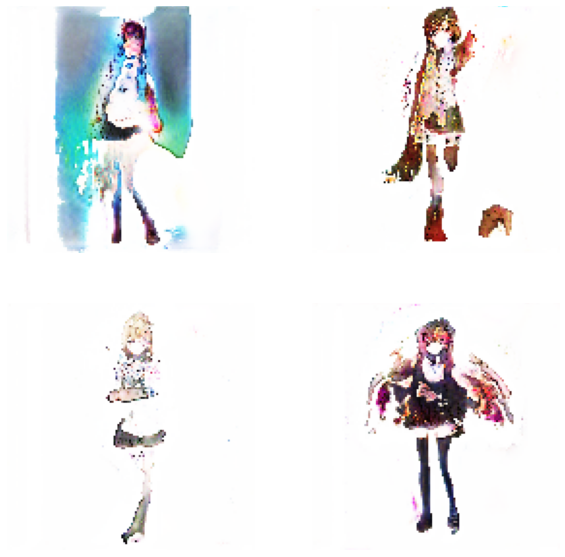

In [ ]:
fake_img = model(noise.cpu(), 0.25, 5)
print(fake_img.shape, 'To')
data = torch.moveaxis(fake_img.cpu().detach()*127.5+127.5,1,-1).numpy().astype(int)
print(data.shape)
double_plotter(fake_img.detach())

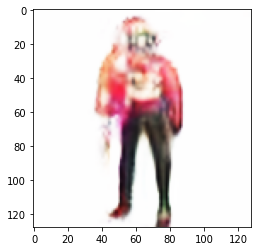

In [ ]:
plt.imshow(data[1])